Testing the tactile gym

In [1]:
from tactile_gym.rl_envs.demo_rl_env_base import demo_rl_env
from tactile_gym.rl_envs.exploration.edge_follow.edge_follow_env import EdgeFollowEnv
from scipy import signal
from scipy import misc

import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt

import torch
import random as rnd
from IPython.display import clear_output 

pybullet build time: Jan 20 2023 16:26:58


First we set up some variables of what we want within the envirnment. 

Number of iterations is how long our training loop will be

max_steps is how many steps each iteration can ake within the environment

show_gui allows us to view or not view a gui showing whats going on

This is the same with show tactle

Rendering is required for showing the gui - it is quicker without



In [2]:

seed = int(0)
num_iter = 100
max_steps = 250
show_gui = True
show_tactile = True
render = True
print_info = False
image_size = [128, 128]


Set up the environment

In [3]:
env_modes = {
    # which dofs can have movement
    "movement_mode": "xy",

    # specify arm
    "arm_type": "ur5",

    # specify tactile sensor
    "tactile_sensor_name": "tactip",
    # "tactile_sensor_name": "digit",
    # "tactile_sensor_name": "digitac",

    # the type of control used
    # "control_mode": "TCP_position_control",
    'control_mode': 'TCP_velocity_control',

    # add variation to embed distance to optimise for
    # warning, don't use rand height when controlling z unless
    # including embed distance in observation
    # 'noise_mode':'fixed_height',
    "noise_mode": "rand_height",

    # which observation type to return
    'observation_mode': 'oracle',
    "observation_mode": "tactile",
    # 'observation_mode':'visual',
    # 'observation_mode':'visuotactile',

    # which reward type to use (currently only dense)
    "reward_mode": "dense"
    # 'reward_mode':'sparse'
}
env = EdgeFollowEnv(
    max_steps=max_steps,
    env_modes=env_modes,
    show_gui=show_gui,
    show_tactile=show_tactile,
    image_size=image_size
)

# set seed for deterministic results
env.seed(seed)
env.action_space.np_random.seed(seed)


argv[0]=
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = 
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Mesa/X.org
GL_RENDERER=llvmpipe (LLVM 12.0.0, 256 bits)
GL_VERSION=4.5 (Core Profile) Mesa 21.2.6
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 21.2.6
Vendor = Mesa/X.org
Renderer = llvmpipe (LLVM 12.0.0, 256 bits)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Mesa/X.org
ven = Mesa/X.org


Activate GUI is selected

In [4]:
# create controllable parameters on GUI
action_ids = []
min_action = env.min_action
max_action = env.max_action
if show_gui:

    if env_modes["movement_mode"] == "xy":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))

    elif env_modes["movement_mode"] == "xyz":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dZ", min_action, max_action, 0))

    elif env_modes["movement_mode"] == "xyRz":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dRz", min_action, max_action, 0))

    elif env_modes["movement_mode"] == "xyzRz":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dZ", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dRz", min_action, max_action, 0))

# run the control loop
#demo_rl_env(env, num_iter, action_ids, show_gui, show_tactile, render, print_info)

Make model for evolution, this uses a convolutional neural network. Weights are assigned randomly.

In [5]:
class Agent_Conv2D:
    def __init__(self, num_input, layers, num_output):
        assert type(layers)==type([]), "Error with layers, give array of the number of layers"
        self.num_input = num_input  #set input number
        self.num_output = num_output #set ooutput number
        self.hidden=[]
        last=num_input
        self.num_genes=0
        for layer in layers:
            self.hidden.append(layer)
            self.num_genes+=(last * layer)
            last=layer
        self.num_genes +=(self.hidden[-1]*num_output)+num_output
        self.weights = None
        self.hidden_weights=None
        self.bias = None
        print("Auto",self.num_genes)
    def set_genes(self, gene):
        weight_idxs = self.num_input * self.hidden[0] #size of weights to hidden
        current=weight_idxs
        weights_idxs=[current] #start with end of last
        for i in range(len(self.hidden)-1):
            current+=self.hidden[i]*self.hidden[i+1] #calculate next idx for each layer
            weights_idxs.append(current)
        bias_idxs=None
        weights_idxs.append(self.hidden[-1] * self.num_output + weights_idxs[-1]) #add last layer heading to output
        bias_idxs = weights_idxs[-1]+ self.num_output #sizes of biases
        w = gene[0 : weight_idxs].reshape(self.hidden[0], self.num_input)   #merge genes
        ws=[]
        for i in range(len(self.hidden)-1):
            ws.append(gene[weights_idxs[i] : weights_idxs[i+1]].reshape(self.hidden[i+1], self.hidden[i]))
        ws.append(gene[weights_idxs[-2] : weights_idxs[-1]].reshape(self.num_output, self.hidden[-1]))
        b = gene[weights_idxs[-1]: bias_idxs].reshape(self.num_output,) #merge genes

        self.weights = torch.from_numpy(w) #assign weights
        self.hidden_weights=[]
        for w in ws:
            self.hidden_weights.append(torch.from_numpy(w))
        self.bias = torch.from_numpy(b) #assign biases

    def forward(self, x):
        #create conv layer
        scharr = np.array([[ -3-3, 0-10,  +3 -3],
                   [-10+0, 0+ 0, +10 +0],
                   [ -3+3, 0+10,  +3 +3]]) # Gx + j*Gy
        x= signal.convolve2d(x, scharr, boundary='symm', mode='same')   
        x=x.flatten()
        x=torch.tensor(x[:,np.newaxis]).float()  
        #x = torch.tensor(np.dot(self.weights.float(),x).flatten()).float()
        #run through forward layers
        x = torch.mm(x.T, self.weights.T.float()) #first layer

        for i in range(len(self.hidden_weights)-1):
            x = torch.mm(x,self.hidden_weights[i].T.float()) #second layer
        x=torch.sigmoid(x)
        return torch.mm(x,self.hidden_weights[-1].T.float()) + self.bias #third layer
    
    def get_action(self, x,vec):
        vec=np.array(vec)
        vectors=[(1,1),(1,0),(0,1),(-1,-1),(-1,0),(0,-1),(-1,1),(1,-1)] #possible moves
        arr=list(self.forward(x,vec)[0])
        ind=np.argmax(arr)
        return vectors[ind]

create an agent and population of genes

In [6]:
sensor=Agent_Conv2D(10*10,[100,60,30],2)
size=sensor.num_genes
def gen_population(pop_size=25):
    population=np.random.normal(0,3,(pop_size,size))
    return population
"""for i in range(pop_size):
    population[i]+=(size))"""

print(gen_population()[0])
population=gen_population()

Auto 17862
[-3.117079 2.696457 -3.079562 ... 0.465490 1.035209 -0.685312]


Fitness function and mutation of genes

In [17]:
MASTER = cv2.imread("/its/home/drs25/Pictures/good.png")
MASTER = cv2.cvtColor(MASTER, cv2.COLOR_BGR2GRAY)
MASTER = cv2.resize(MASTER, dsize=(10,10), interpolation=cv2.INTER_AREA) #rescale

def get_similarity(img1,img2):
    diff = cv2.absdiff(img1, img2)
    return np.sum(diff)/(10*10*255)

def new_fitness(tactile):
    return get_similarity(MASTER,tactile)
    
def fitness(tactile):
    #lets say we want to maximize the lighter pixels 
    all=np.sum(tactile)
    all=(all/255)/(50*50)
    return all
def mutation(gene, mean=0, std=0.5,size=100):
    assert size<len(gene)
    n=rnd.randint(0,len(gene)-size-1)
    array=np.random.normal(mean,std,size=size)
    gene = gene[n:n+size] + array #mutate the gene via normal 
    # constraint
    gene[gene >4] = 4
    gene[gene < -4] = -4
    return gene

def crossover(loser, winner, p_crossover=0.5): #provide a crossover function
    for i,gene in enumerate(winner):
      if rnd.random() <= p_crossover:
        loser[i] = winner[i]
    return loser

show what agent sees

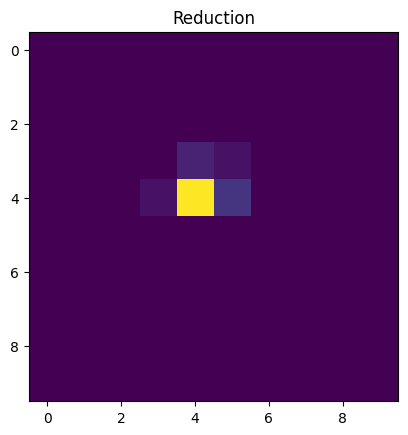

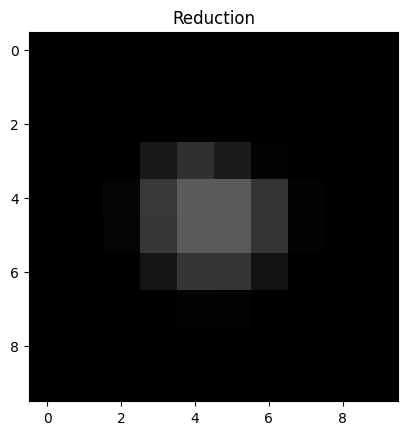

In [8]:
o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
tactile_input=np.reshape(o['tactile'],(128,128))
tactile_input=cv2.resize(tactile_input, dsize=(10,10), interpolation=cv2.INTER_AREA) #rescale

plt.title("Reduction")
plt.imshow(tactile_input)
plt.show()

img1 = cv2.imread("/its/home/drs25/Pictures/good.png")
img1 = cv2.resize(img1, dsize=(10,10), interpolation=cv2.INTER_AREA) #rescale

plt.title("Reduction")
plt.imshow(img1)
plt.show()

Applying the microbial GA algorithm

In [19]:
def run_trial(gene,max_t,save=None):
    dt=0.1
    t=0
    done=False
    r_sum = 0
    o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
    step = 0
    sensor.set_genes(gene) #set the gene of the robot
    while not done and t<=max_t: #loop till sturdy or out of time
        tactile_input=np.reshape(o['tactile'],(128,128))
        tactile_input=cv2.resize(tactile_input, dsize=(10,10), interpolation=cv2.INTER_AREA) #rescale
        a=torch.sin(sensor.forward(tactile_input))[0] #push through tactile input into agent
        # step the environment
        o, r, d, info = env.step(a) #step through environment
        #print(a,env.action_space.sample())
        fit=new_fitness(tactile_input)
        r_sum +=fit
        if fit>=0.5: done=True #if it is sturdy
        t+=dt #increase by timestep
        if save!=None: save.append(env.render())
    return r_sum, env.render() #we care about the last fitnesses as it should be sturdy

def run_microbial(population,generations): #microbial algorithm trial
    fitnesses=[0]
    rendered=[]
    bestInd=-1
    r1=None
    r2=None
    try:
        for i in range(generations):
            clear_output()
            print("GEN: ",i,"REWARD: ",fitnesses[-1])
            #select neighbouring genes
            ind_1 = rnd.randint(0,len(population)-1)
            ind_2=ind_1+1
            if ind_2 >= len(population): ind_2=ind_1-1
            #get two random positions
            gene1=population[ind_1]
            gene2=population[ind_2]
            #run trials for 20 seconds in sim time
            f1=0
            for i in range(3): #run 3 trials to make sure there is no fluke
                f,r1=run_trial(gene1,3)
                f1+=f
            fit1=f1/3 #get average performance
            f2=0
            for i in range(3): #run 3 trials for fluke
                f,r1=run_trial(gene2,3)
                f2+=f
            fit2=f2/3
            if fit1>fitnesses[-1] and fit1<fit2: 
                rendered.append(r1)
                bestInd=ind_1
            elif fit2>fitnesses[-1]:
                rendered.append(r2)
                bestInd=ind_2
            fitnesses.append(max([fitnesses[-1],fit1,fit2]))
            #selection
            if fit1>fit2:
                gene2=copy.deepcopy((gene1)) #crossover
                population[ind_2]=copy.deepcopy(crossover(gene2,mutation(gene1)))
            elif fit2>fit1:
                gene1=copy.deepcopy((gene2)) #crossover
                population[ind_1]=copy.deepcopy(crossover(gene1,mutation(gene2)))
    except KeyboardInterrupt:
        pass
            
    return fitnesses, rendered, bestInd
GENERATIONS=300
pop=gen_population()
f,r,ind=run_microbial(pop,GENERATIONS)

GEN:  38 REWARD:  0.00963581699346405


KeyboardInterrupt: 

5


TypeError: Image data of dtype object cannot be converted to float

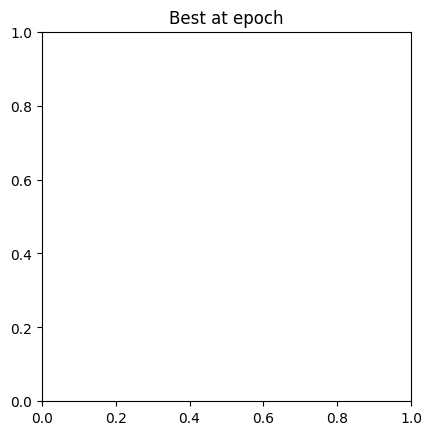

In [ ]:

print(len(r))
for i in range(len(r)):
    plt.title("Best at epoch")
    plt.imshow(r[i])
    plt.show()


What live demo of the best genotype

In [ ]:

arr=[]
best=0
best_ind=0
for ind in range(len(pop)):
    arr_=[]
    f,r=run_trial(pop[ind],3,save=arr_)
    if f>best:
        best=f
        best_ind=ind
        arr=copy.deepcopy(arr_)


In [ ]:
arr=[]
f,r=run_trial(pop[best_ind],10,save=arr)

Saving the demo

In [ ]:
import cv2 as cv
h,w=arr[0].shape[:2]
out = cv.VideoWriter('./Gym_tactip.avi',cv.VideoWriter_fourcc(*'DIVX'), 15, (w,h))
#gen vid
for i,j in enumerate(arr):
    out.write(j)
out.release()